CatBoost Modelling

In [1]:
import pandas as pd
import numpy as np
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split
from dataclasses import dataclass

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
from expected_score_model.evaluation.model_evaluator import ModelEvaluator
from expected_score_model.evaluation.classification_evaluator import ClassificationModelEvaluator
from expected_score_model.evaluation.regression_evaluator import RegressionModelEvaluator
# from expected_score_model.evaluation.xgboost_evaluator import XGBoostEvaluator

In [3]:
from expected_score_model.preprocessing.preprocessor import ExpectedScorePreprocessor
from expected_score_model.preprocessing.response import create_expected_score_response

Data

In [4]:
chains = pd.read_csv('/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/data/AFL_Chains.csv')

In [5]:
chains = create_expected_score_response(chains)

In [6]:
chains.head()

CD_Player_ID  Chain_Number Team_Chain Initial_State Final_State  \
0          NaN             1   Brisbane  centreBounce    turnover   
1   CD_I293535             1   Brisbane  centreBounce    turnover   
2   CD_I293535             1   Brisbane  centreBounce    turnover   
3  CD_I1002401             1   Brisbane  centreBounce    turnover   
4  CD_I1002401             1   Brisbane  centreBounce    turnover   

   Period_Number  Period_Duration_Chain_Start        Description   Disposal  \
0            1.0                          0.0      Centre Bounce        NaN   
1            1.0                          0.0      Hard Ball Get        NaN   
2            1.0                          0.0           Handball  effective   
3            1.0                          0.0  Handball Received        NaN   
4            1.0                          0.0           Handball  effective   

  Shot_At_Goal Behind_Detail  Order  Period_Duration     x     y Home_Team  \
0          NaN           NaN    1.0              0.0   0.0   0.0    Sydney   
1          NaN           NaN    2.0              8.0 -12.0 -11.0    Sydney   
2          NaN           NaN    3.0              8.0 -13.0 -11.0    Sydney   
3          NaN           NaN    4.0             10.0 -19.0 -13.0    Sydney   
4          NaN           NaN    5.0             10.0 -19.0 -11.0    Sydney   

  Away_Team Home_Team_Direction_Q1  Venue_Width  Venue_Length  \
0  Brisbane                  right        141.0         160.0   
1  Brisbane                  right        141.0         160.0   
2  Brisbane                  right        141.0         160.0   
3  Brisbane                  right        141.0         160.0   
4  Brisbane                  right        141.0         160.0   

               Player      Team                     Match_ID  \
0                 NaN       NaN  AFL_2024_F4_Sydney_Brisbane   
1        Lachie Neale  Brisbane  AFL_2024_F4_Sydney_Brisbane   
2        Lachie Neale  Brisbane  AFL_2024_F4_Sydney_Brisbane   
3  Brandon Starcevich  Brisbane  AFL_2024_F4_Sydney_Brisbane   
4  Brandon Starcevich  Brisbane  AFL_2024_F4_Sydney_Brisbane   

            Player_ID result  score  miss  behind  goal  
0                 NaN   miss      0     1       0     0  
1        lachie_neale   miss      0     1       0     0  
2        lachie_neale   miss      0     1       0     0  
3  brandon_starcevich   miss      0     1       0     0  
4  brandon_starcevich   miss      0     1       0     0

Preprocessing

In [7]:
xs_preproc = ExpectedScorePreprocessor()
X_shots, y_shots = xs_preproc.fit_transform(chains, chains['result'])

In [8]:
result_map = {
    'behind': 0,
    'goal': 1,
    'miss': 2
}
y_shots = y_shots.map(result_map)

In [9]:
X_shots.head(1)

angle  angle_degrees  chain_duration description_0 description_1  \
47  0.321751      18.434949            68.0          Kick  Mark On Lead   

            description_2  description_3   distance  distance_log  \
47  Kick Inside 50 Result  Kick Into F50  37.947332      3.636199   

    distance_since_last_action  distance_squared  distance_to_goal_x  \
47                    8.246211            1440.0                36.0   

    distance_to_middle_y  ground_kick initial_state  period_duration_0  \
47                  12.0            0      possGain              118.0   

    period_duration_1  period_duration_2  period_duration_3  set_shot  \
47               76.0               74.0               72.0         1   

    time_since_last_action  visible_behind_angle  \
47                    42.0              0.512821   

    visible_behind_angle_degrees  visible_goal_angle  \
47                     29.382451            0.161146   

    visible_goal_angle_degrees   x_0   x_1   x_2   x_3   y_0   y_1   y_2   y_3  
47                    9.232981  44.0  52.0  51.0  34.0  12.0  10.0  10.0  55.0

Feature Selection

In [10]:
selected_features = ['distance', 'angle', 'set_shot', 'distance_since_last_action']
X_shots_selected = X_shots[selected_features]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_shots_selected, y_shots, test_size=0.2, random_state=42)

Hyperparameter Tuning

In [12]:
training_data = X_train
response = y_train
validation_size = 0.2

In [13]:
@dataclass
class OptunaXGBParamGrid:
    trials: int = 10
    verbosity: int = 0
    error: str = "multi:softprob"
    num_class: int = 3
    num_rounds: int = 1000
    early_stopping_rounds: int = 50
    eta_min: float = 0.01
    eta_max: float = 1.0
    max_depth_min: int = 2
    max_depth_max: int = 20
    max_depth_step: int = 1
    min_child_weight_min: int = 2
    min_child_weight_max: int = 100
    min_child_weight_step: int = 1
    gamma_min: float = 0.0001
    gamma_max: float = 10
    lambda_min: float = 0.0001
    lambda_max: float = 10
    alpha_min: float = 0.0001
    alpha_max: float = 10
    subsample_min: float = 0.2
    subsample_max: float = 0.9
    subsample_step: float = 0.05
    colsample_bytree_min: float = 0.2
    colsample_bytree_max: float = 0.9
    colsample_bytree_step: float = 0.05
    validation_size: float = 0.2      

In [14]:
xgb_param_grid = OptunaXGBParamGrid()

In [15]:
from expected_score_model.modelling.hyperparameter_tuning.xgboost import HyperparameterTuner

In [16]:
xgb_tuner = HyperparameterTuner(training_data=X_train, response = y_train, param_grid=xgb_param_grid)

In [17]:
xgb_tuner.tune_hyperparameters()

[I 2025-01-02 21:05:30,923] A new study created in memory with name: no-name-f438a410-19b5-4943-a169-1ad8243b1339
[I 2025-01-02 21:05:31,186] Trial 0 finished with value: 0.9563379147940306 and parameters: {'max_depth': 12, 'min_child_weight': 94, 'eta': 0.4430919160501232, 'gamma': 0.01071259177010711, 'lambda': 0.45461799807149755, 'alpha': 0.09089480445148865, 'subsample': 0.6610421749071511, 'colsample_bytree': 0.480733014094859}. Best is trial 0 with value: 0.9563379147940306.
[I 2025-01-02 21:05:31,639] Trial 1 finished with value: 1.0351769068278651 and parameters: {'max_depth': 13, 'min_child_weight': 4, 'eta': 0.04665802375847747, 'gamma': 0.0063482370887085774, 'lambda': 0.00022672461279081533, 'alpha': 0.5710769930987123, 'subsample': 0.3429311662599057, 'colsample_bytree': 0.6373018859047417}. Best is trial 0 with value: 0.9563379147940306.
[I 2025-01-02 21:05:31,784] Trial 2 finished with value: 1.0206841822252903 and parameters: {'max_depth': 2, 'min_child_weight': 27, 'e

Number of finished trials:  10
Best trial:
  Value: 0.9563379147940306
  Params: 
    max_depth: 12
    min_child_weight: 94
    eta: 0.4430919160501232
    gamma: 0.01071259177010711
    lambda: 0.45461799807149755
    alpha: 0.09089480445148865
    subsample: 0.6610421749071511
    colsample_bytree: 0.480733014094859


In [18]:
best_params = xgb_tuner.get_best_params()

Fitting Model

In [19]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [20]:
param = {
    'objective': xgb_param_grid.error,
    'num_class': xgb_param_grid.num_class,
    **best_params
}

In [21]:
import xgboost as xgb

In [22]:
xgb_clf = xgb.XGBClassifier(**param)
xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=0.09089480445148865, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.480733014094859, early_stopping_rounds=None,
              enable_categorical=False, eta=0.4430919160501232,
              eval_metric=None, feature_types=None, gamma=0.01071259177010711,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.45461799807149755,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=94, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)

In [23]:
probas = xgb_clf.predict_proba(X_test)

In [24]:
probas

array([[0.10540914, 0.8398321 , 0.05475871],
       [0.19857948, 0.7737479 , 0.02767266],
       [0.57279557, 0.35302854, 0.07417589],
       ...,
       [0.48917925, 0.2647486 , 0.24607213],
       [0.45090607, 0.21589452, 0.3331994 ],
       [0.46341547, 0.3091902 , 0.2273943 ]], dtype=float32)

Export Joblib

In [25]:
import joblib

In [26]:
joblib.dump(xgb_clf, '/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models/xgboost_model.joblib')

['/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models/xgboost_model.joblib']

Get Predictions

In [27]:
class_names = list(result_map.keys())
class_probabilities = {f'predicted_proba_{class_names[i]}': probas[:, i] for i in range(len(class_names))}

In [28]:
predicted_score = class_probabilities['predicted_proba_goal']*6 + class_probabilities['predicted_proba_behind']*1
predicted_result = np.array([np.argmax(x) for x in probas])

In [29]:
score = chains.loc[y_test.index, 'score']
goal = chains.loc[y_test.index, 'goal']
behind = chains.loc[y_test.index, 'behind']
miss = chains.loc[y_test.index, 'miss']

actuals_binary = np.array(chains.loc[y_test.index, class_names])

Model Evaluation

In [30]:
model_eval = ModelEvaluator(model = xgb_clf)

In [31]:
model_eval.averages(actual = score, predicted = predicted_score)

{'actual': 3.333373134328358, 'predicted': 3.2949517}

In [32]:
model_eval.averages(actual = goal, predicted = class_probabilities['predicted_proba_goal'])

{'actual': 0.4982686567164179, 'predicted': 0.49174562}

In [33]:
model_eval.averages(actual = behind, predicted = class_probabilities['predicted_proba_behind'])

{'actual': 0.3437611940298507, 'predicted': 0.3444782}

In [34]:
model_eval.averages(actual = miss, predicted = class_probabilities['predicted_proba_miss'])

{'actual': 0.15797014925373135, 'predicted': 0.1637762}

Modelled Features

In [35]:
xgb_clf.feature_names_in_

array(['distance', 'angle', 'set_shot', 'distance_since_last_action'],
      dtype='<U26')

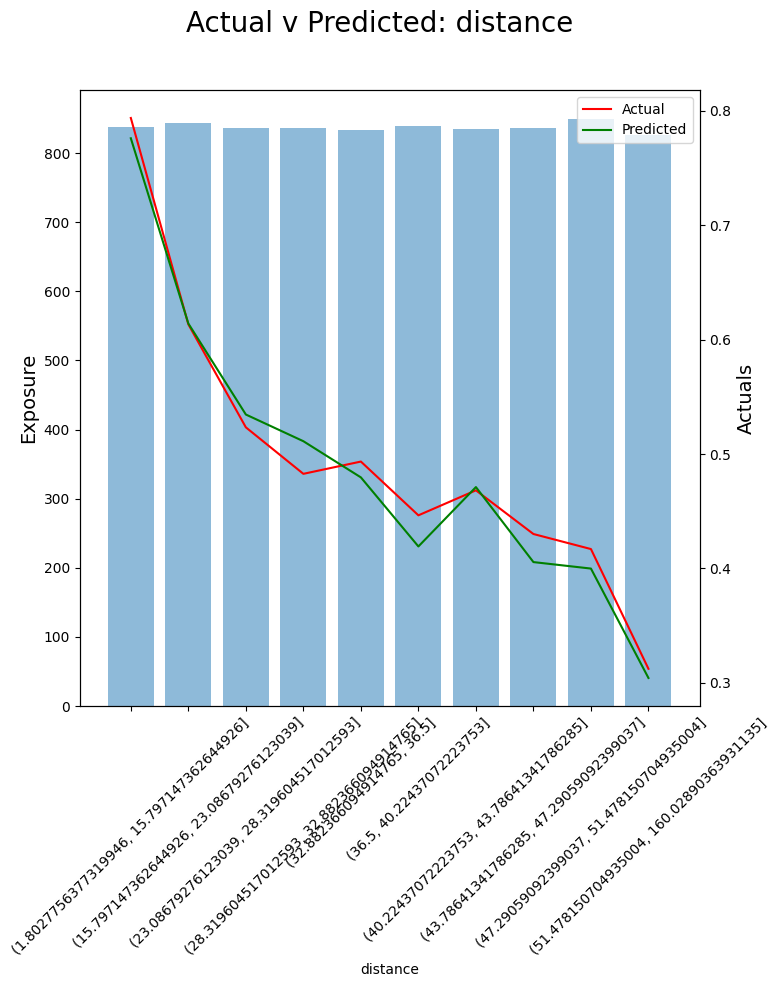

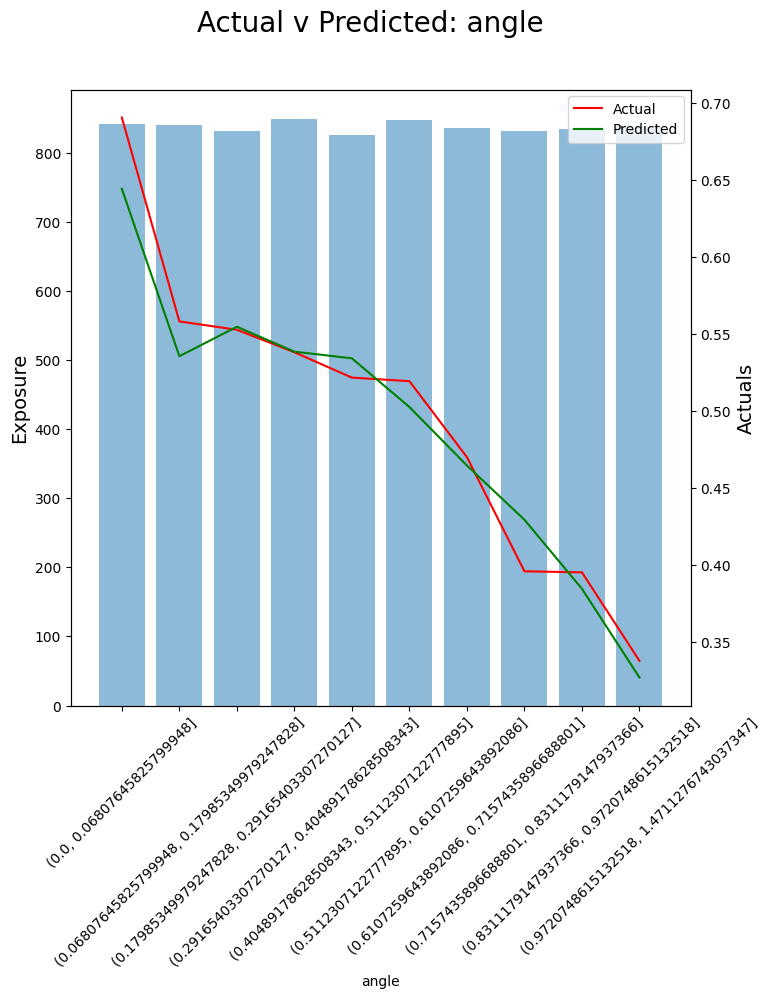

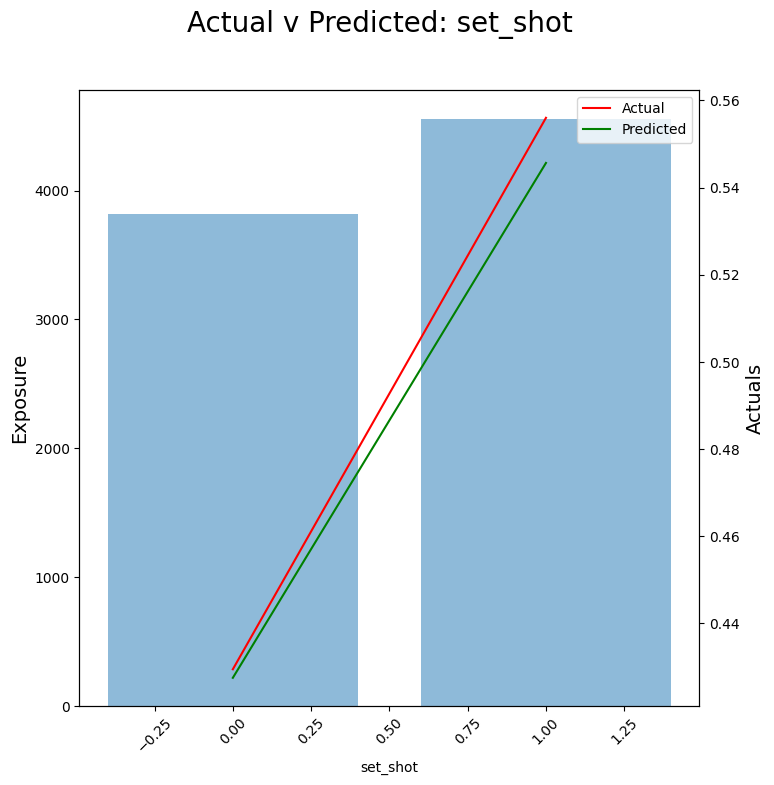

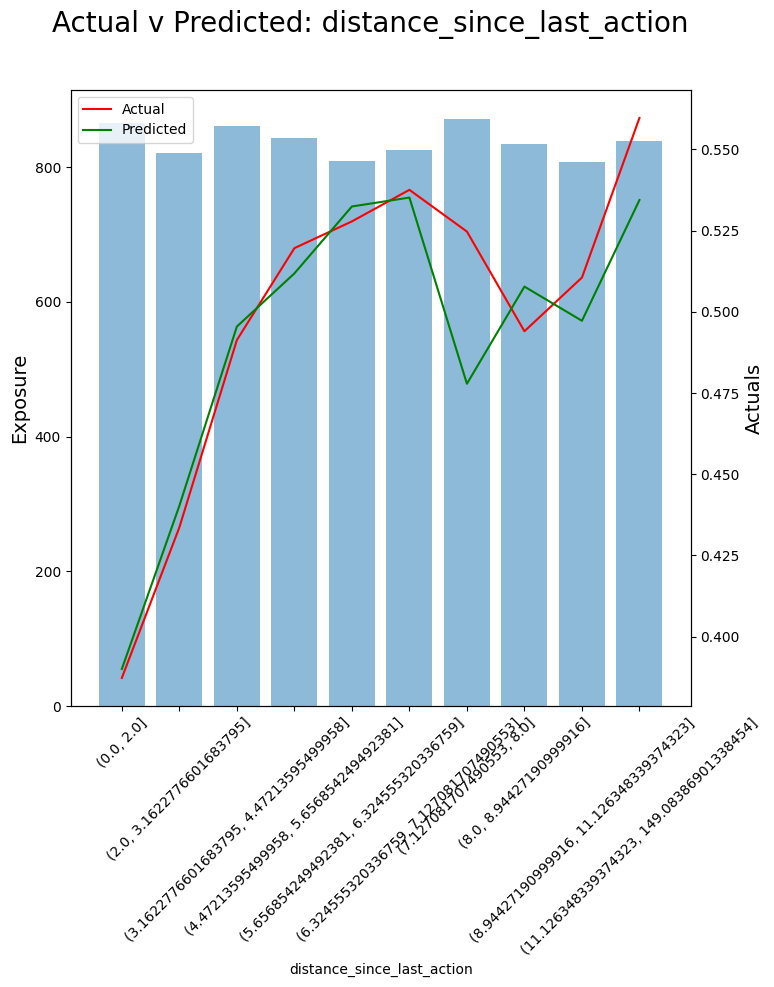

In [36]:
for feature in xgb_clf.feature_names_in_:
    fig, ax = model_eval.plot_feature_ave(actual = goal, predicted = class_probabilities['predicted_proba_goal'], feature = X_test[feature], feature_name = feature)

Extra Features

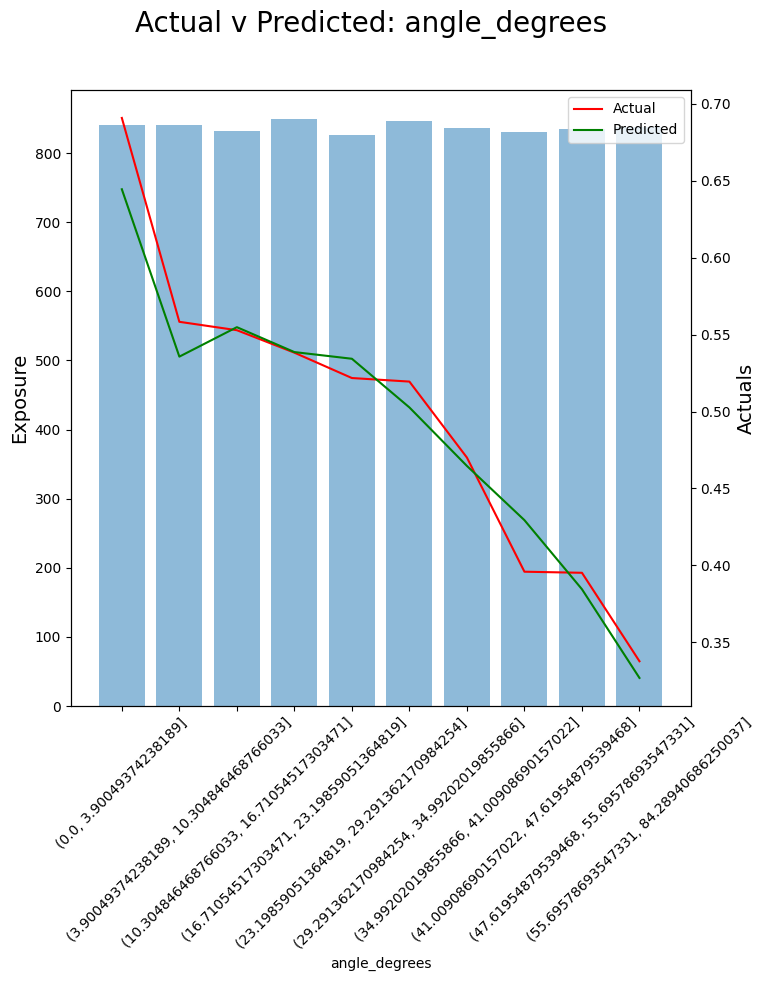

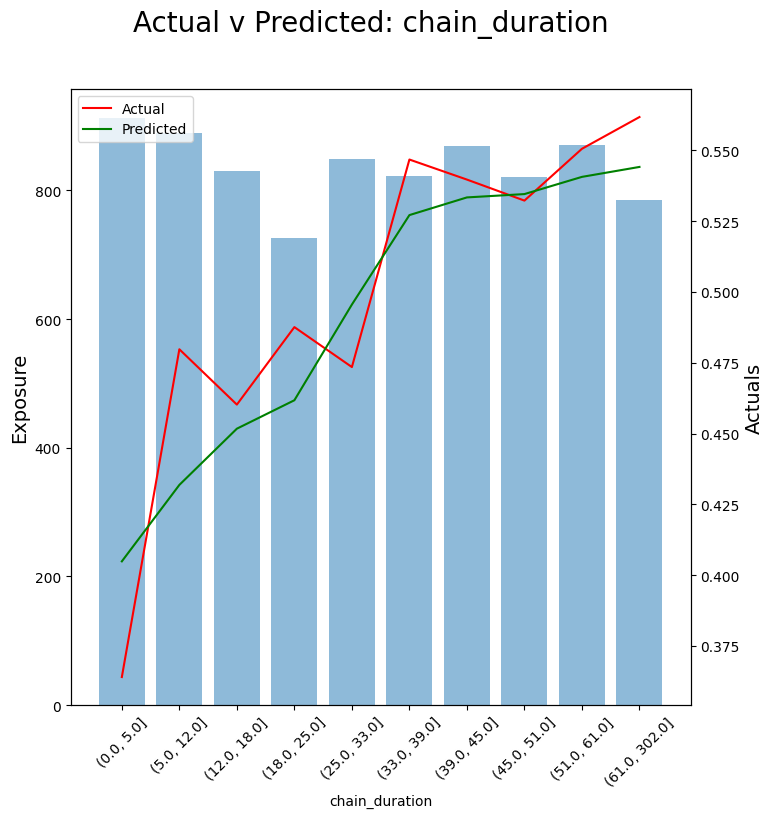

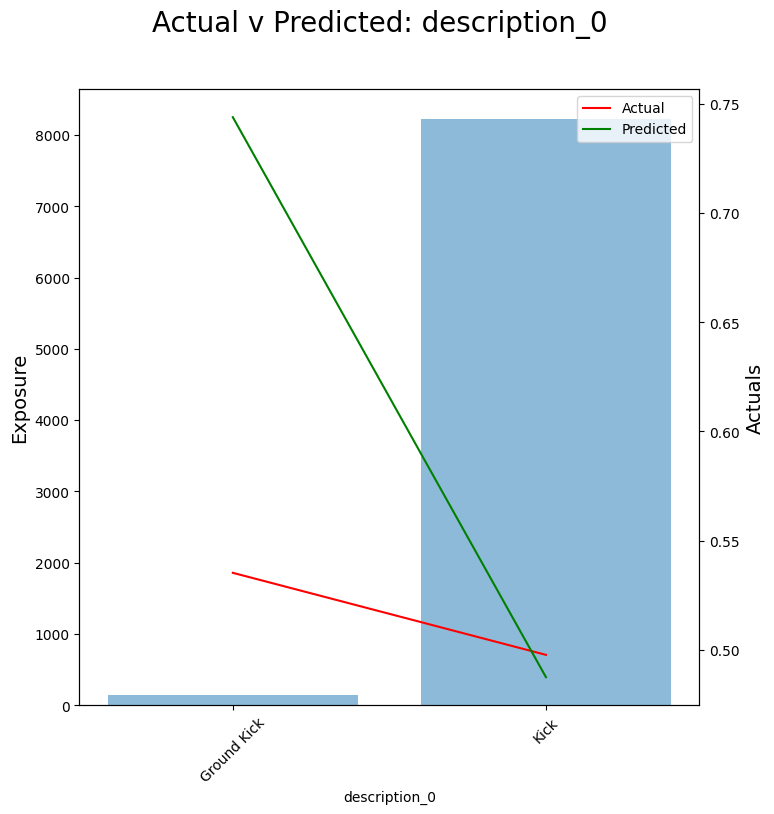

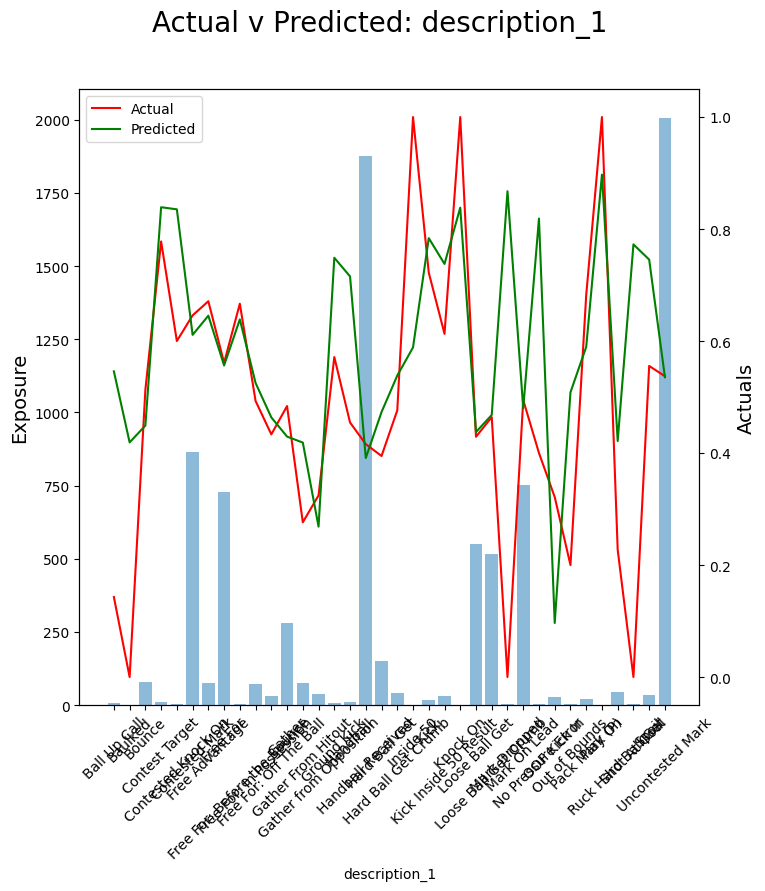

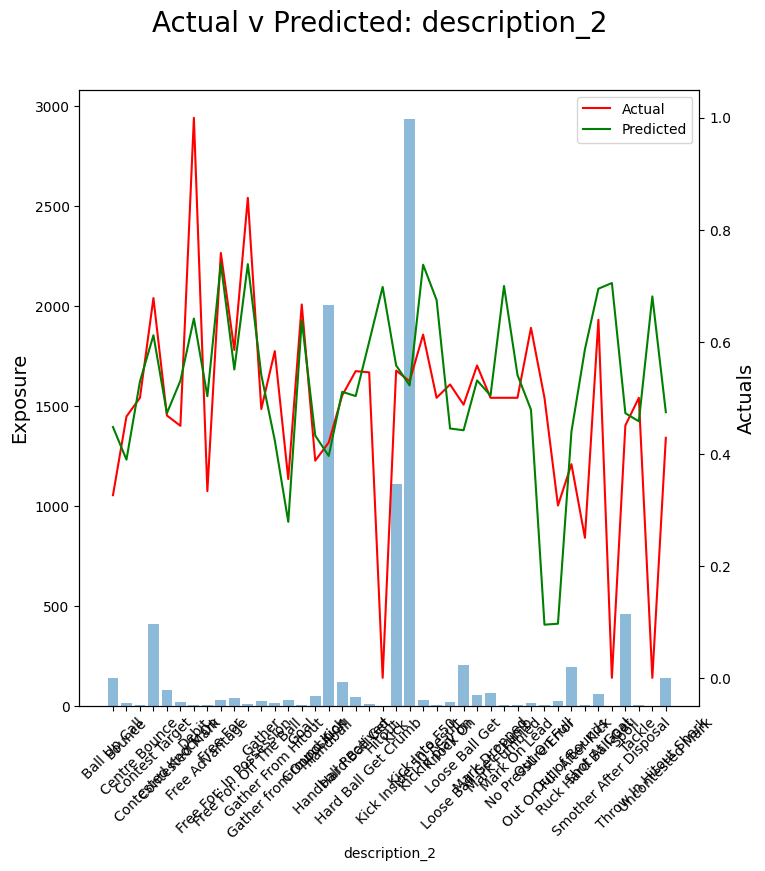

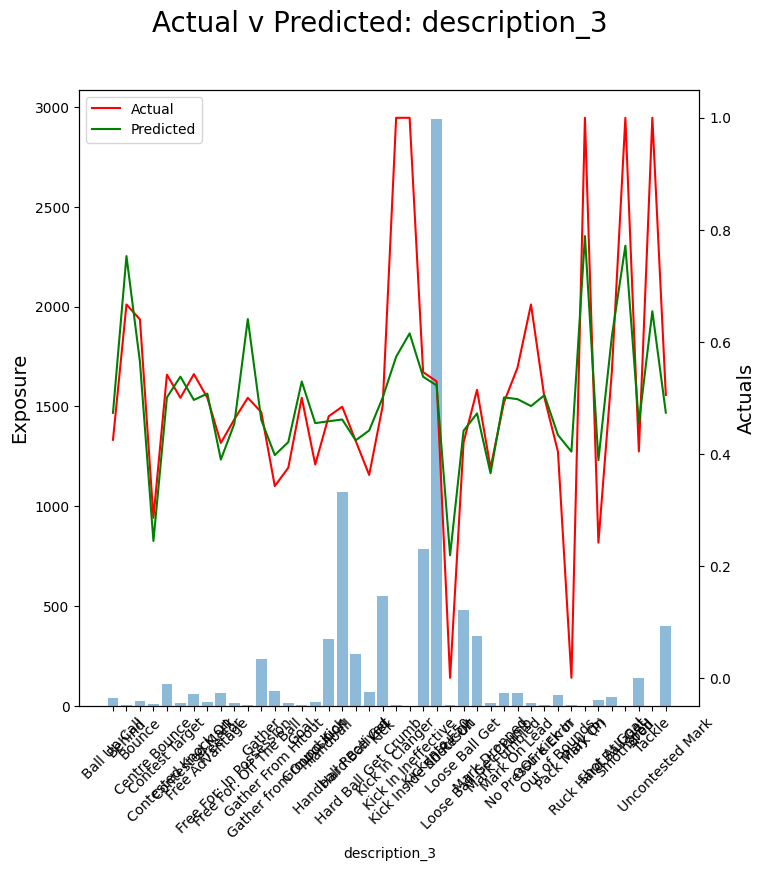

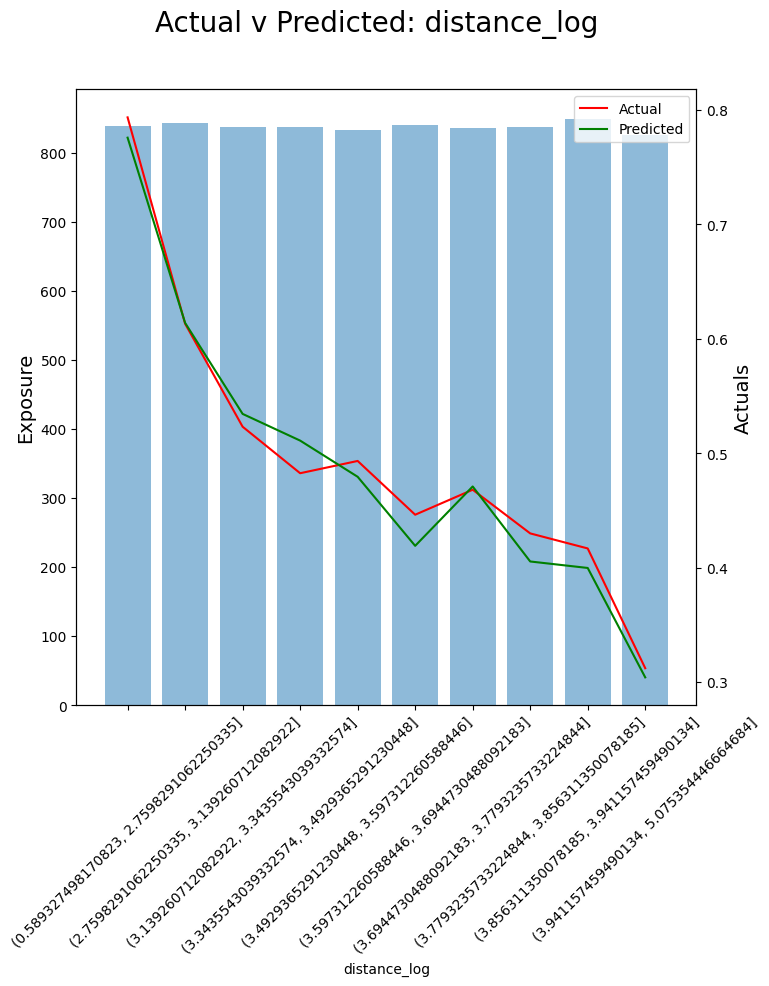

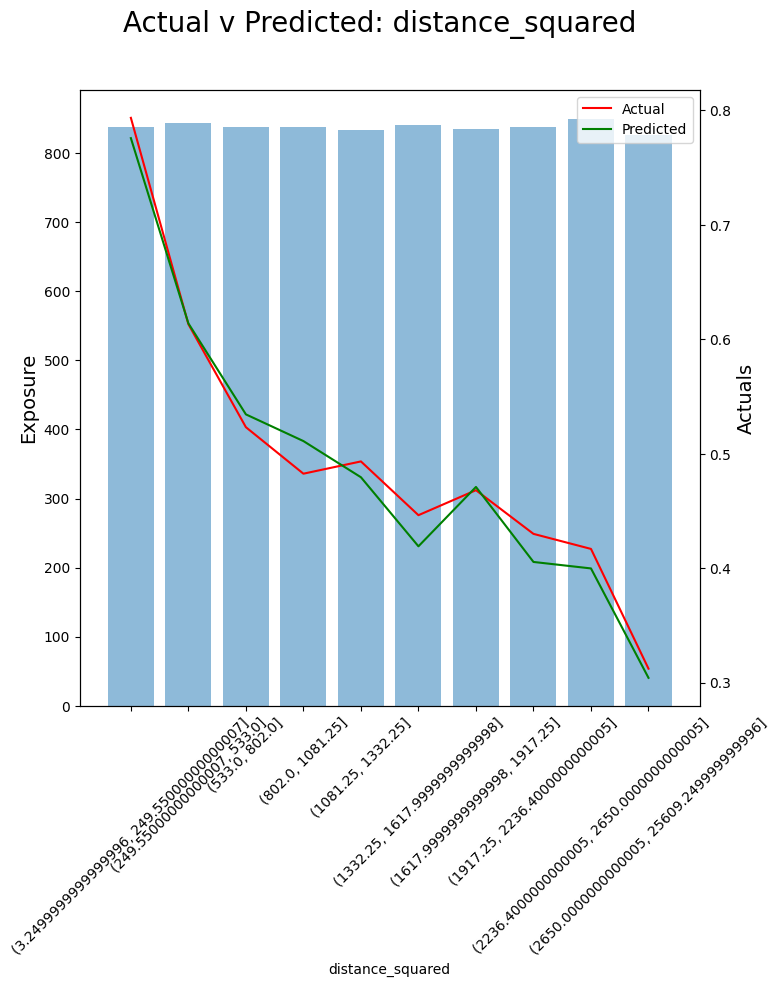

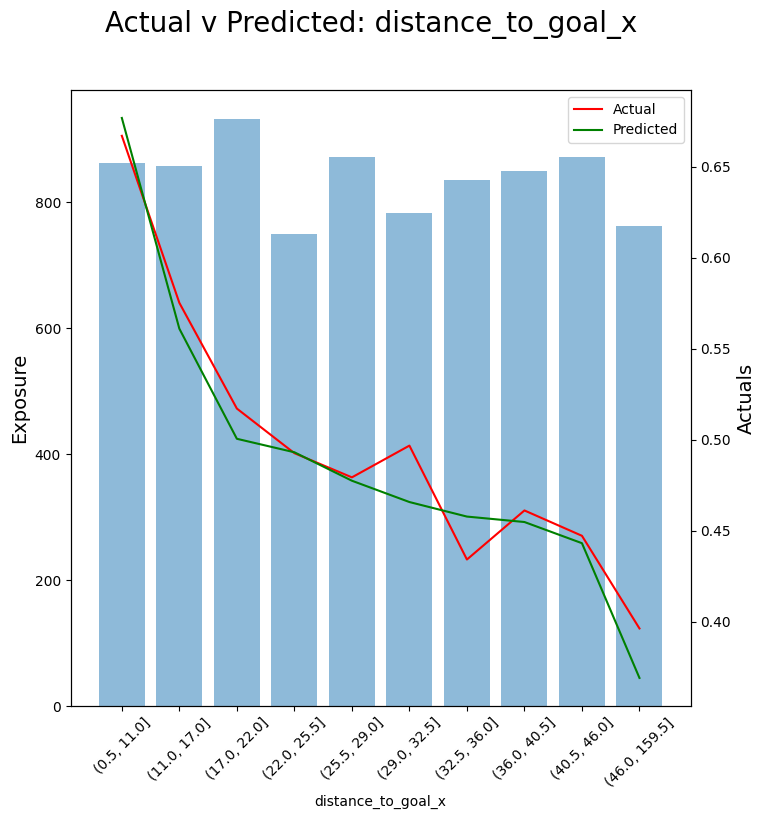

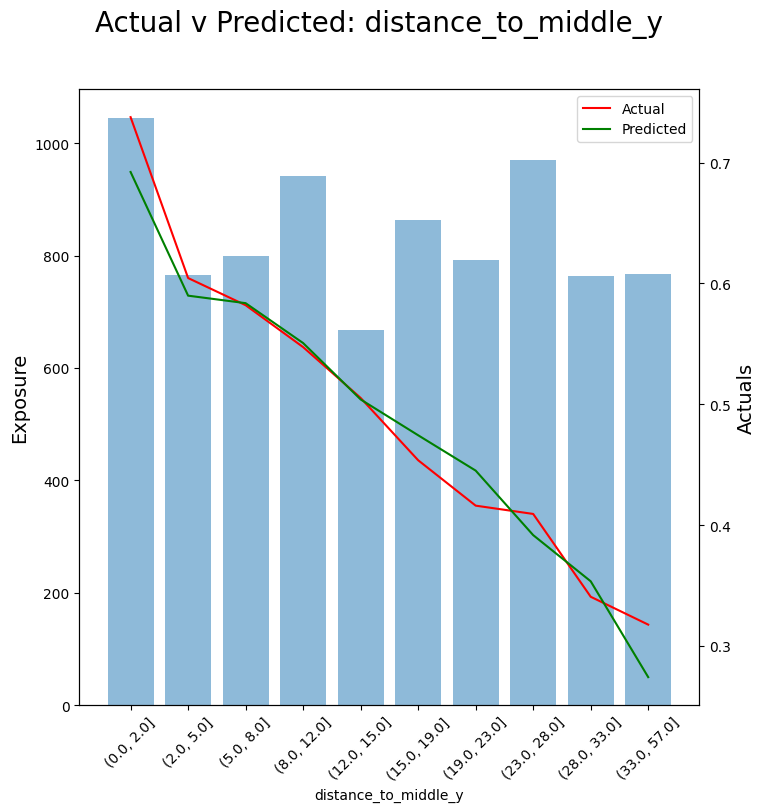

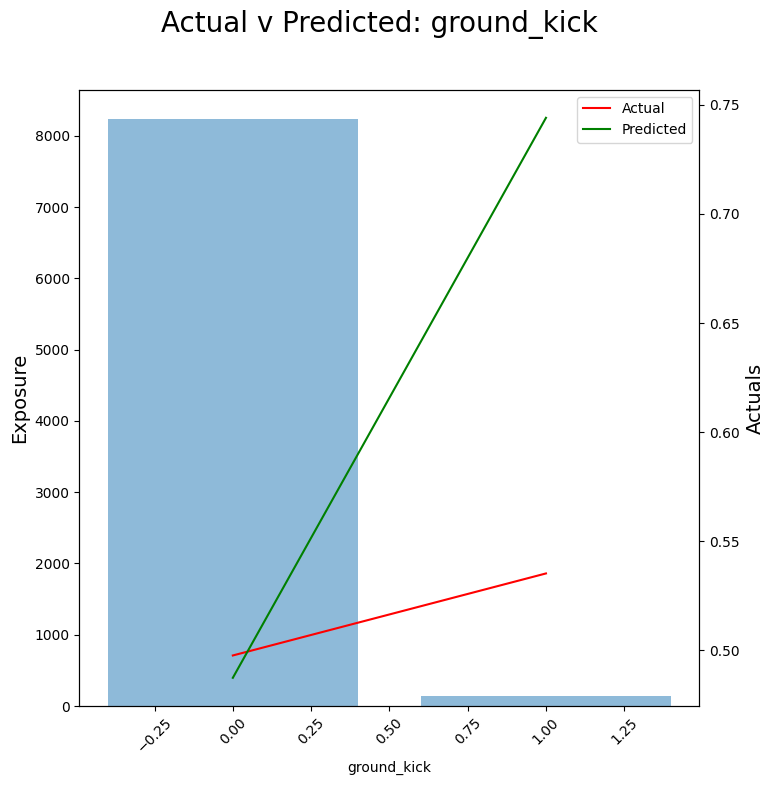

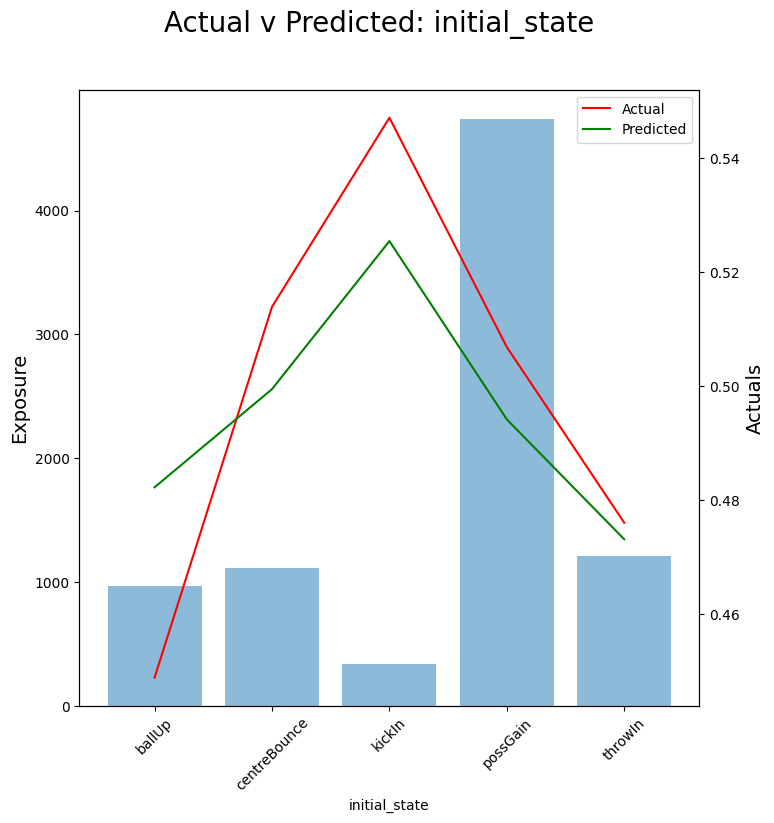

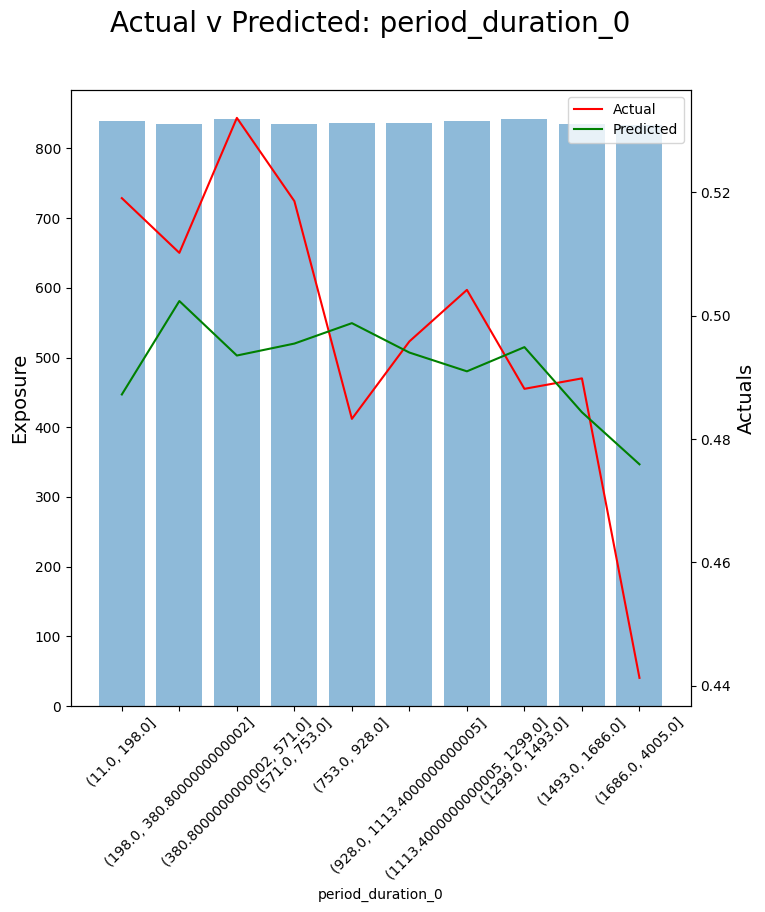

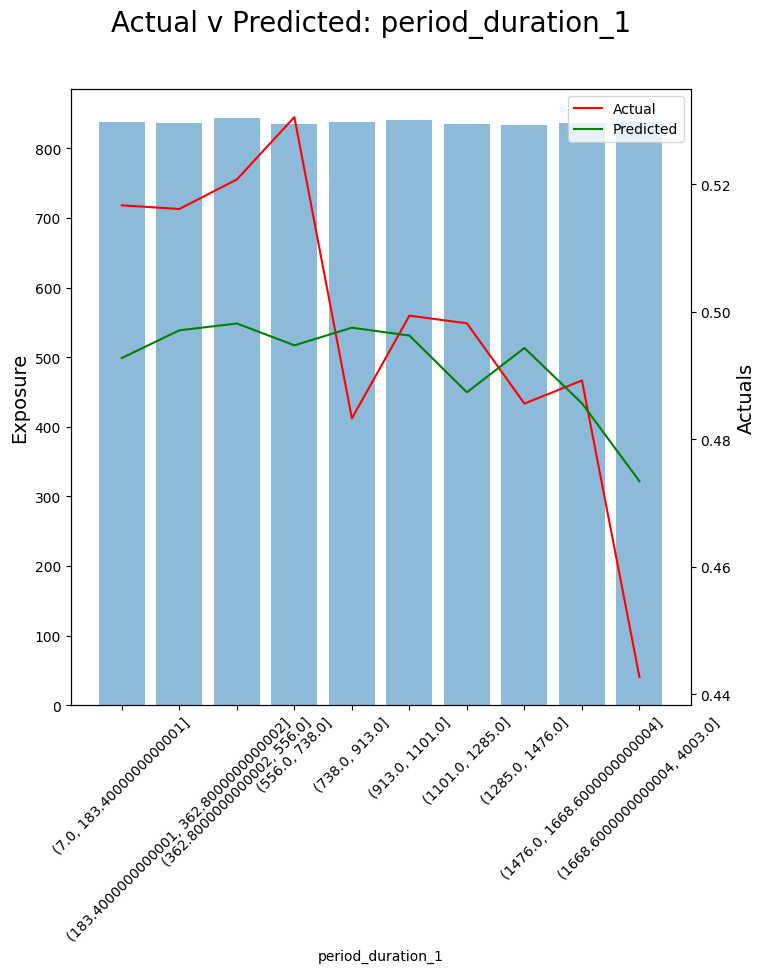

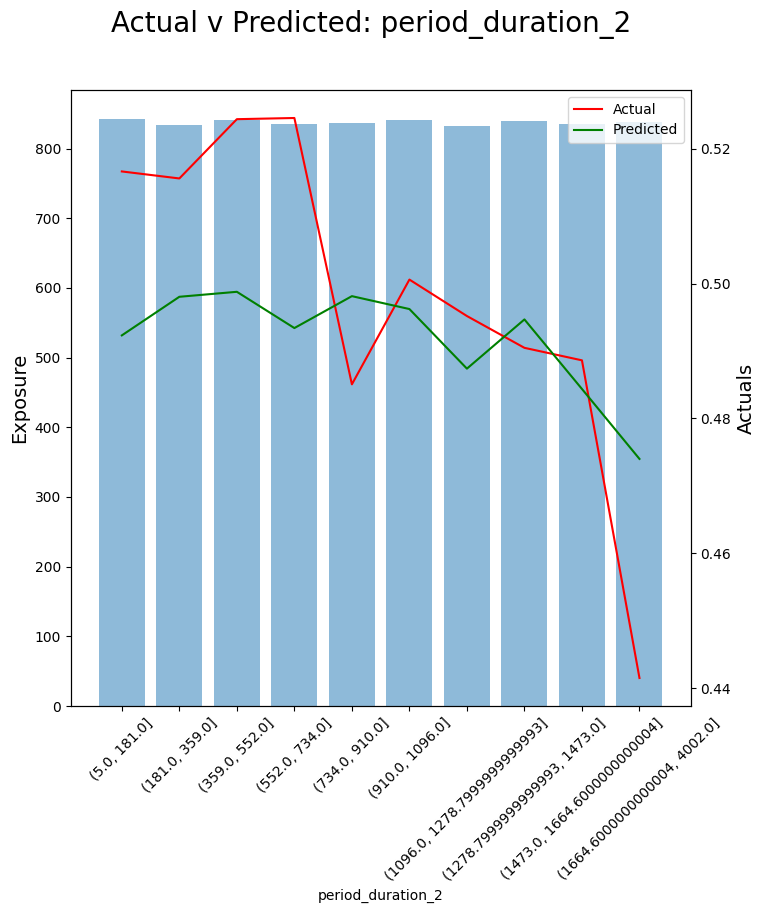

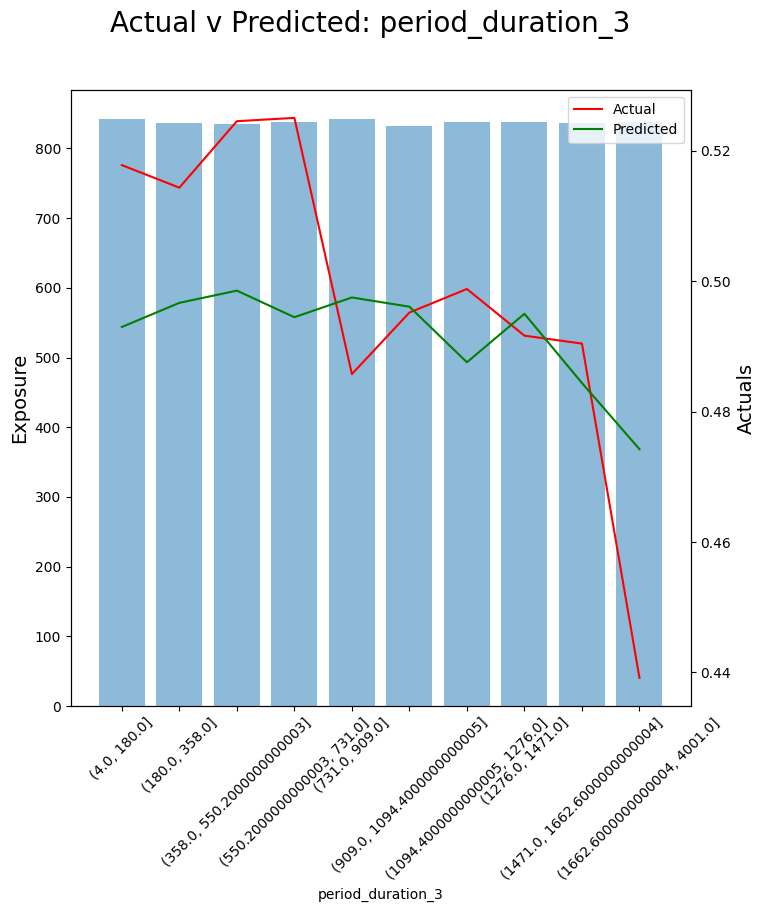

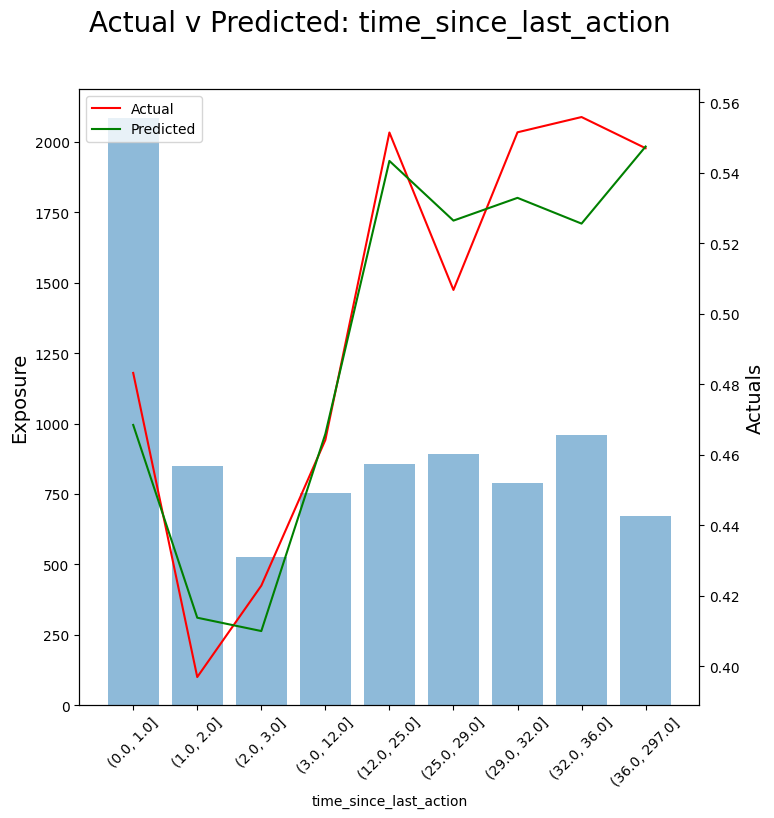

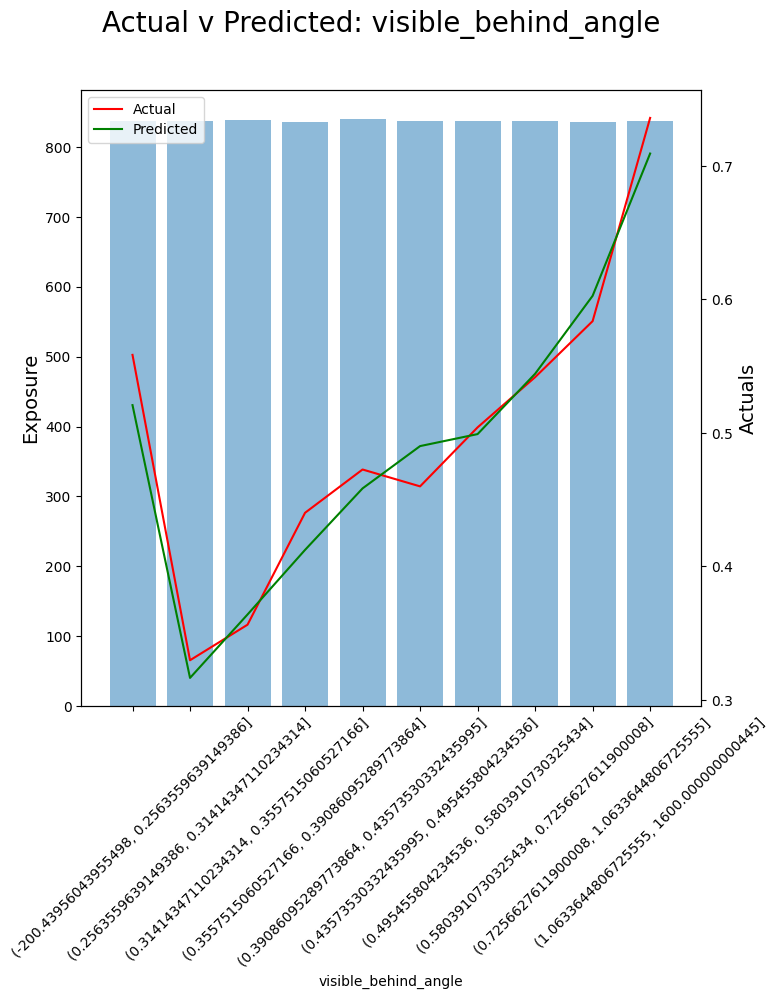

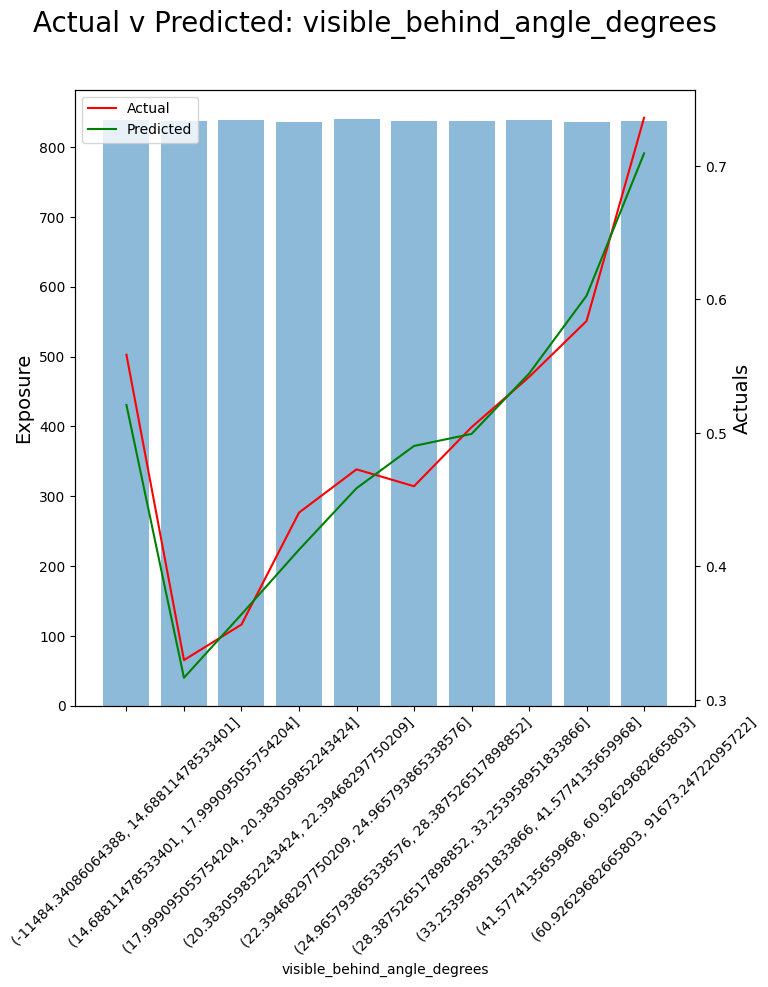

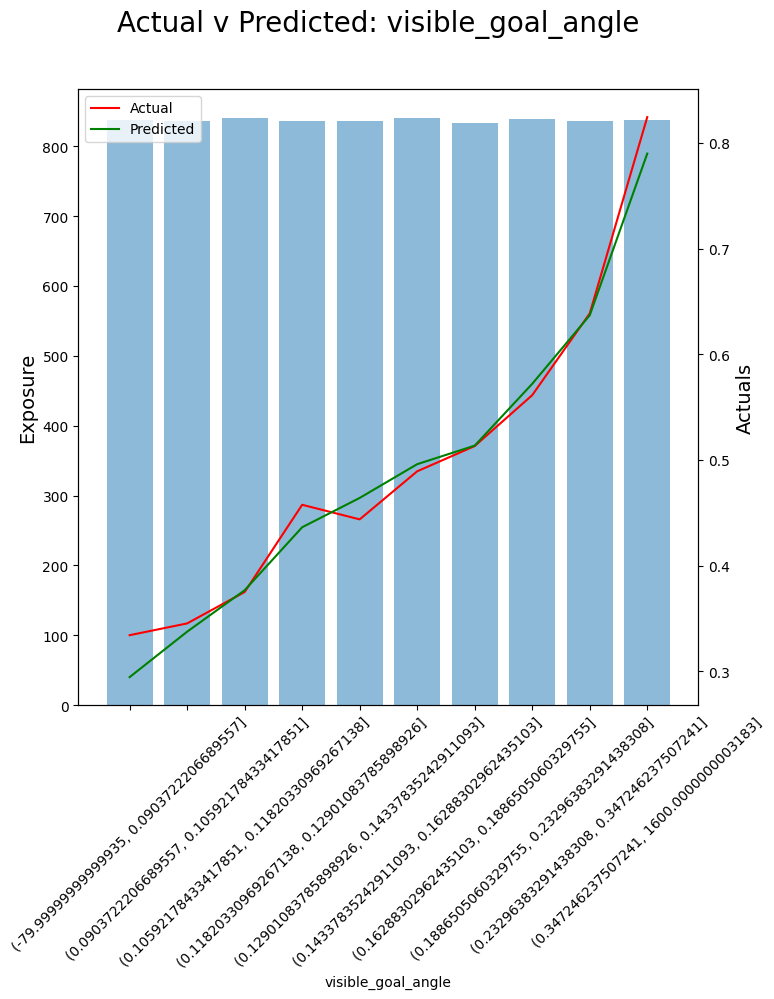

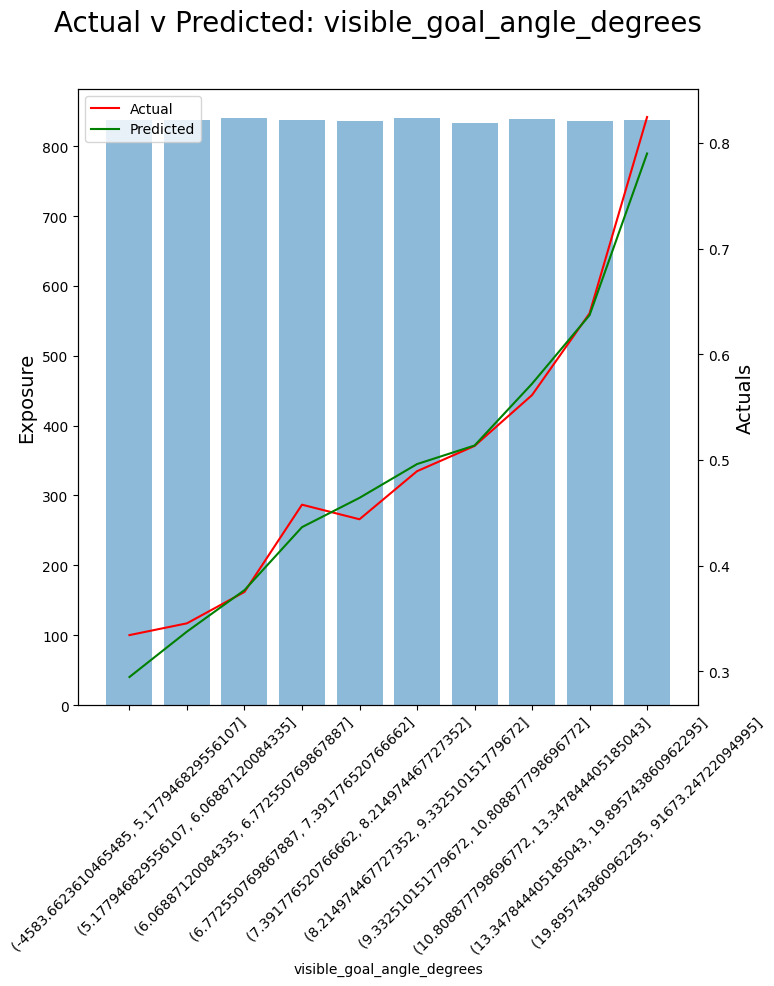

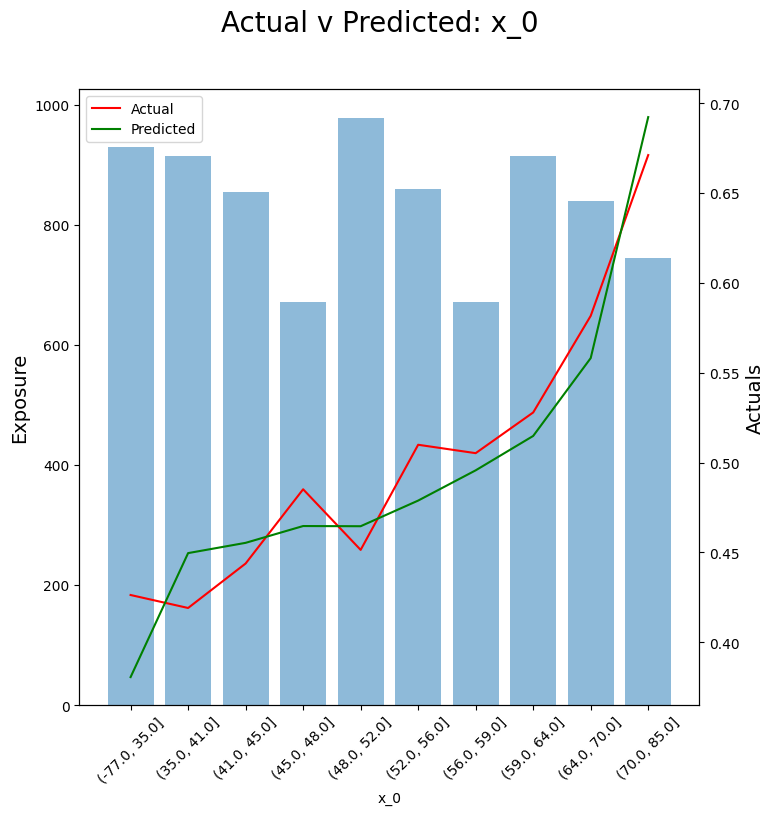

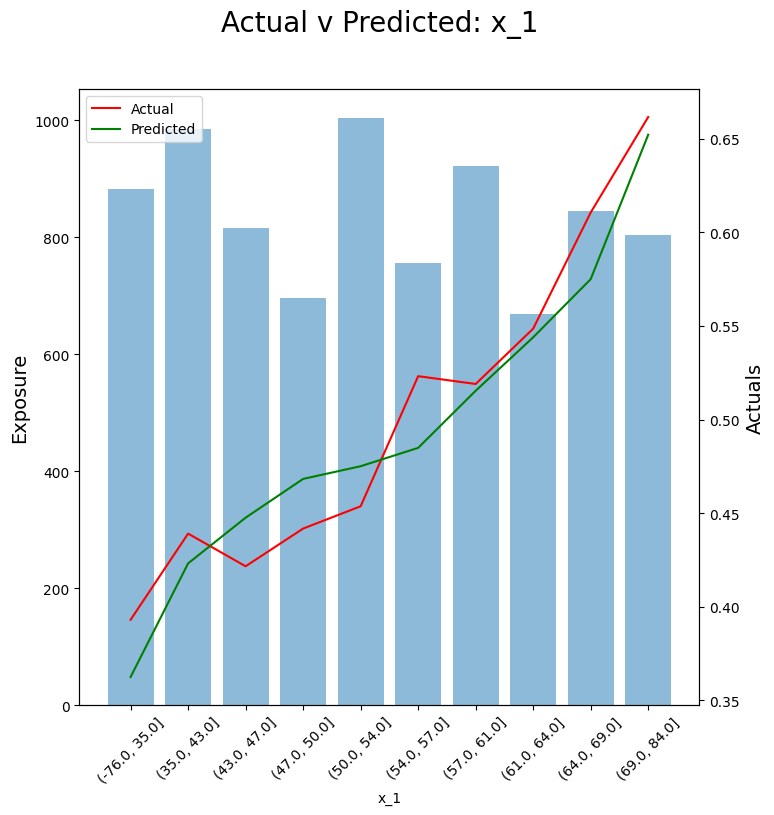

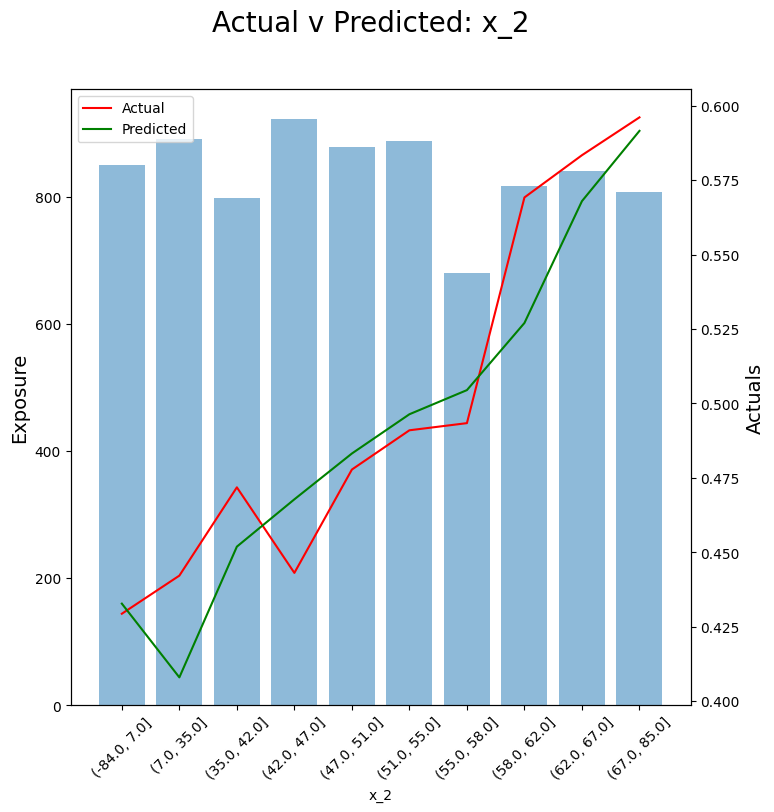

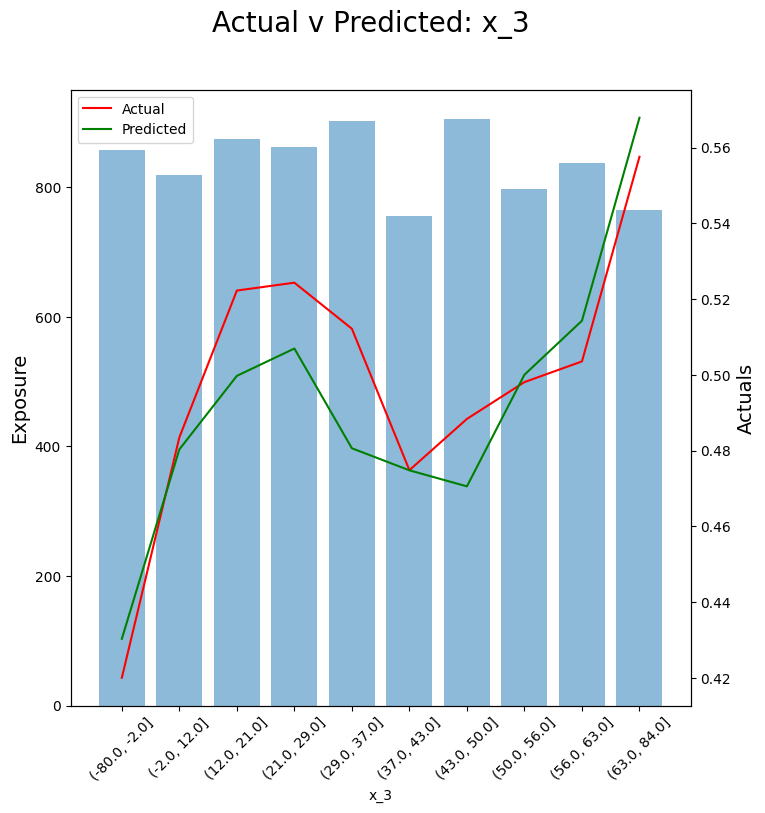

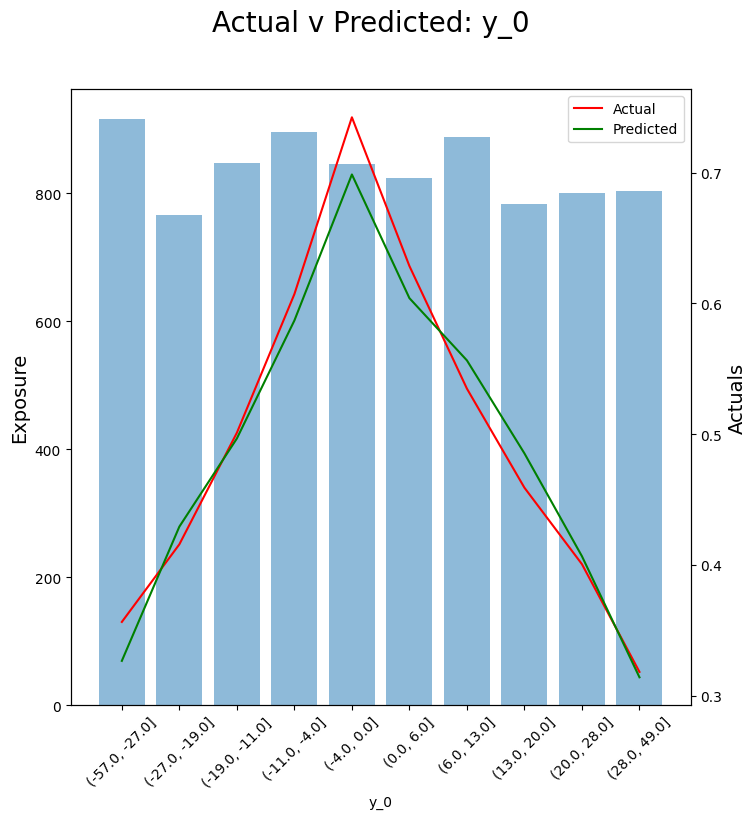

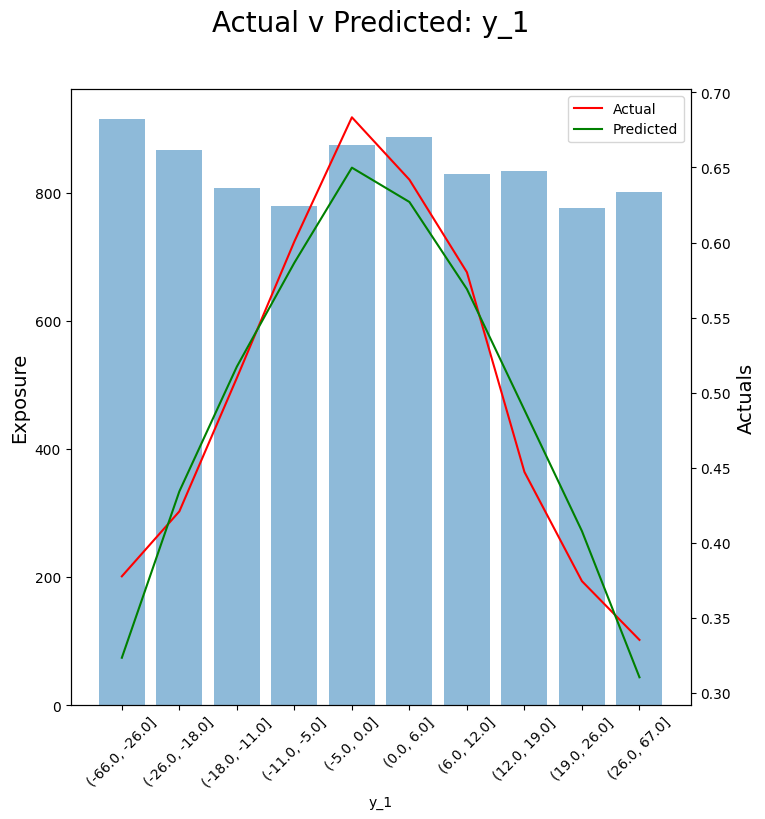

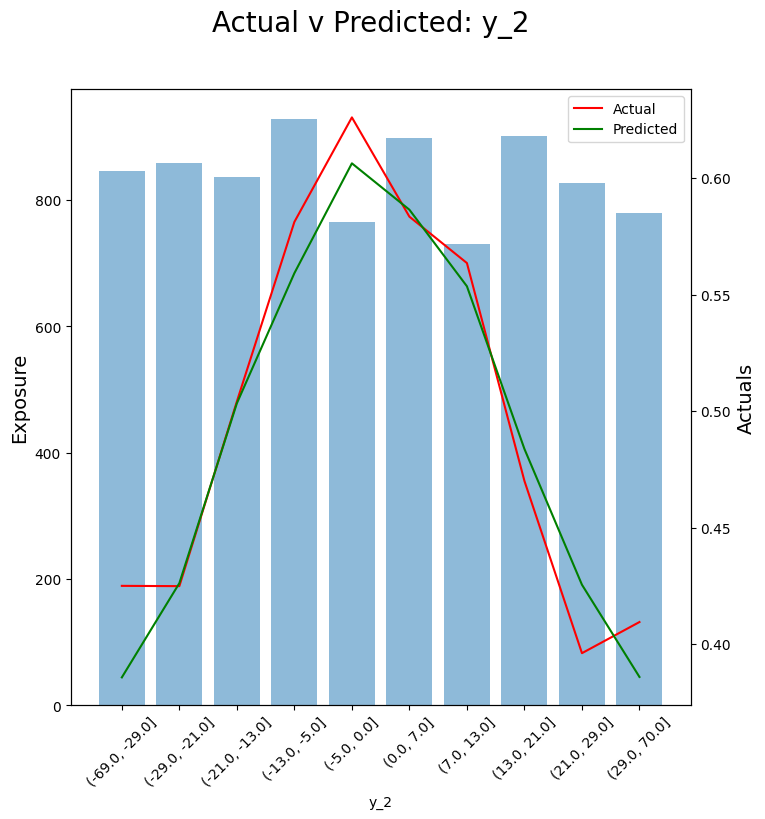

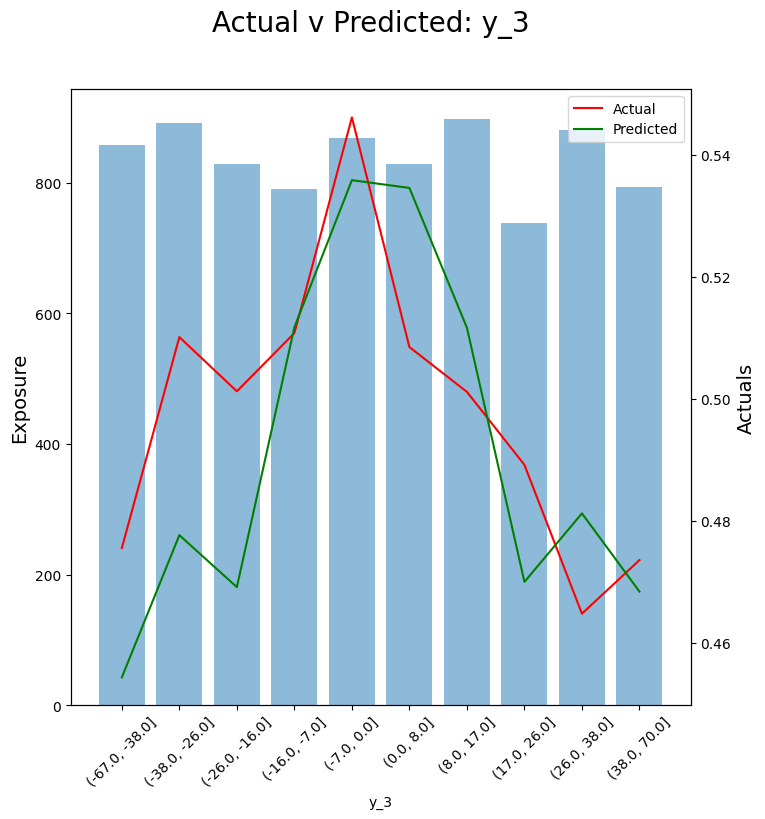

In [37]:
candidate_features = sorted(list(set(X_shots.columns) - set(X_shots_selected)))
for feature in candidate_features:
    fig, ax = model_eval.plot_feature_ave(actual = goal, predicted = class_probabilities['predicted_proba_goal'], feature = X_shots.loc[X_test.index][feature], feature_name = feature)

Classification

In [38]:
multi_class_model_eval = ClassificationModelEvaluator(model = xgb_clf, classification_type='multi')

In [39]:
actual_label = y_test
predicted_label = predicted_result

In [40]:
multi_class_model_eval.get_log_loss(actual = actuals_binary, predictions = probas)

{'class_0': 0.6259368615230708,
 'class_1': 0.6218154801907434,
 'class_2': 0.39445356517847874}

In [41]:
multi_class_model_eval.get_brier_score_loss(actual = actuals_binary, predictions = probas)

{'class_0': 0.21956968366759502,
 'class_1': 0.21669009293426933,
 'class_2': 0.12356425503729385}

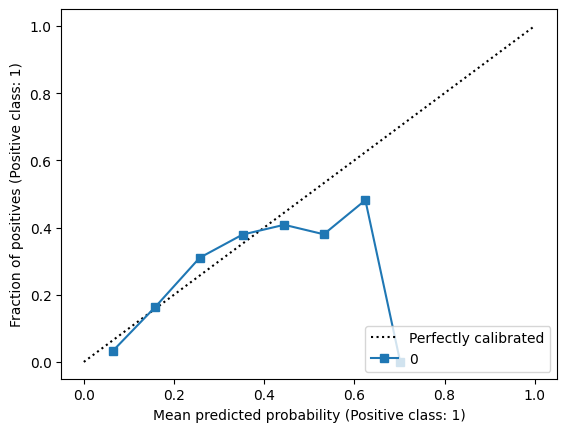

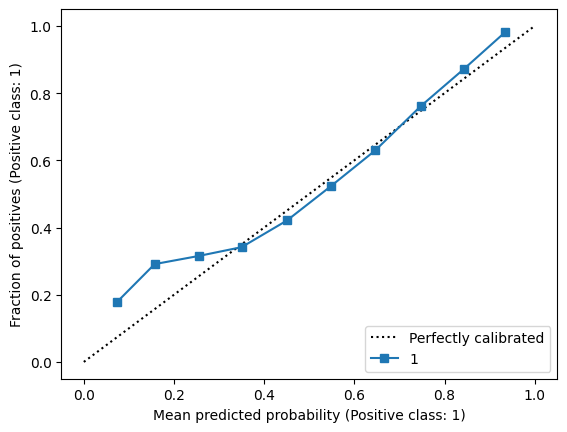

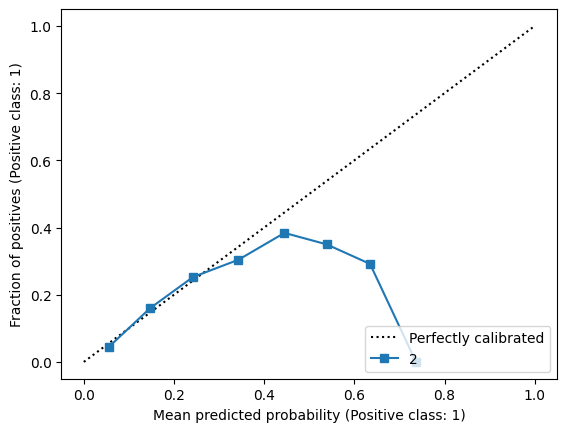

In [42]:
multi_class_model_eval.display_calibration_curve(actual = actuals_binary, predictions = probas, nbins=10) 

In [43]:
multi_class_model_eval.get_confusion_matrix(actual_label=actual_label, predicted_label=predicted_label)

array([[1085, 1640,  154],
       [ 866, 3195,  112],
       [ 675,  502,  146]])

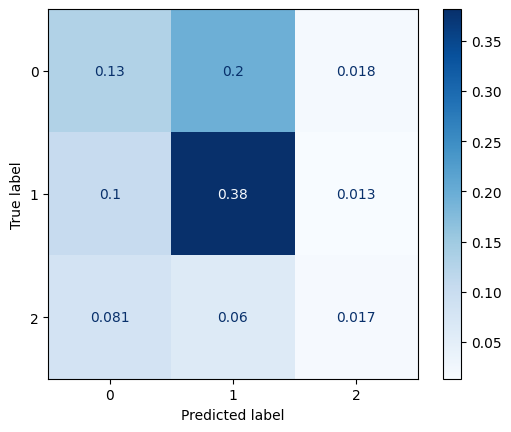

In [44]:
multi_class_model_eval.display_confusion_matrix(actual_label=actual_label, predicted_label=predicted_label)

In [45]:
specified_class = 'goal'
class_label = np.where(actual_label == specified_class, 1, 0)
predicted_class_label = np.where(predicted_label == specified_class, 1, 0)

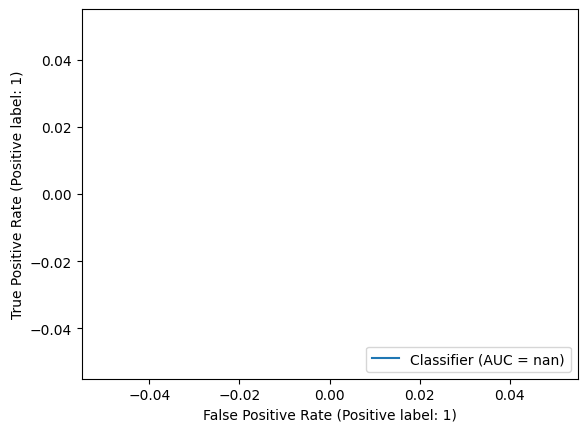

In [46]:
multi_class_model_eval.plot_roc_curve(actual_label=class_label, predicted_label=predicted_class_label)

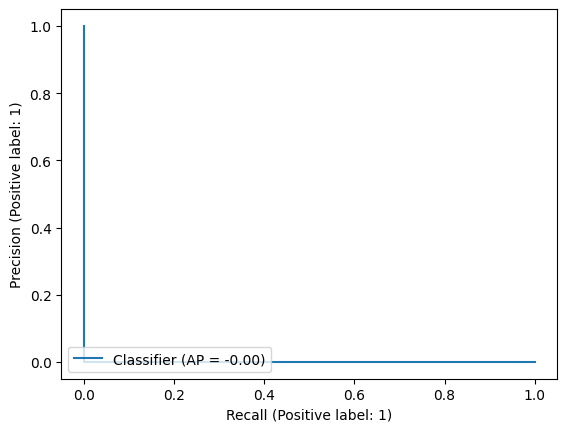

In [47]:
multi_class_model_eval.plot_prauc_curve(actual_label=class_label, predicted_label=predicted_class_label)

In [48]:
regression_model_eval = RegressionModelEvaluator(model = xgb_clf)

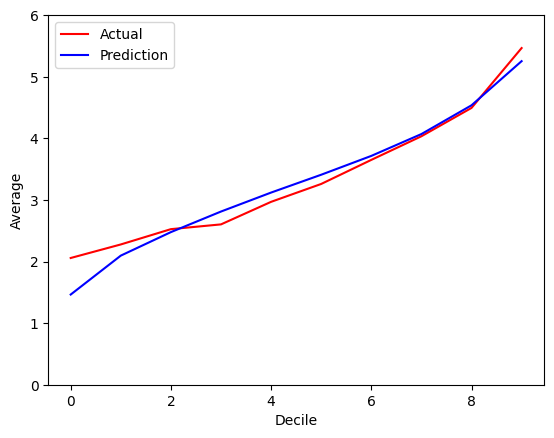

In [49]:
fig, ax = regression_model_eval.plot_decile(actual = score, predictions = predicted_score)

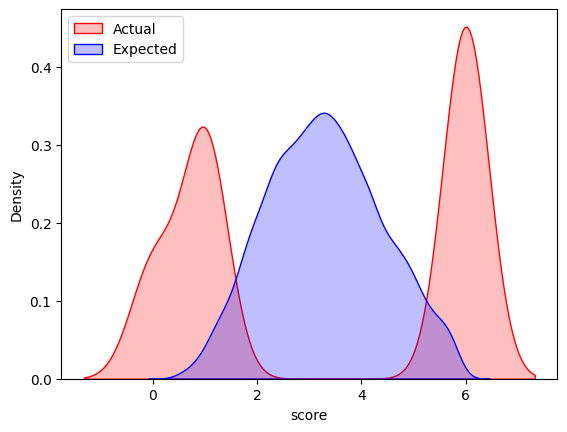

In [50]:
fig, ax = regression_model_eval.plot_distribution(actual = score, predictions = predicted_score)

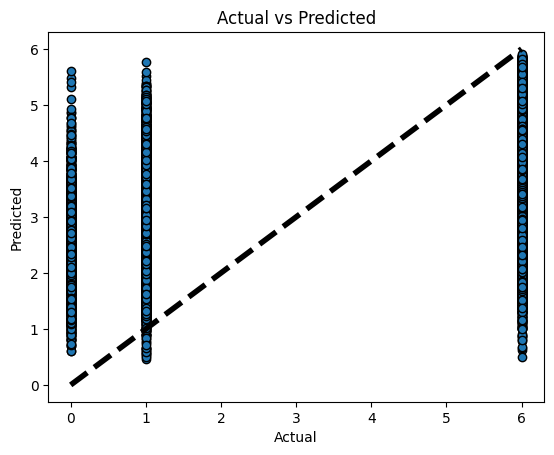

In [51]:
fig, ax = regression_model_eval.plot_ave(actual = score, predictions = predicted_score)

CatBoost Evaluation

In [52]:
from expected_score_model.evaluation.xgboost_evaluator import XGBoostEvaluator

In [53]:
xgb_clf

XGBClassifier(alpha=0.09089480445148865, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.480733014094859, early_stopping_rounds=None,
              enable_categorical=False, eta=0.4430919160501232,
              eval_metric=None, feature_types=None, gamma=0.01071259177010711,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.45461799807149755,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=94, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)

In [54]:
xgb_model_evaluator = XGBoostEvaluator(
    xgb_model = xgb_clf,
    evaluator = ClassificationModelEvaluator
)   

# Feature Importance

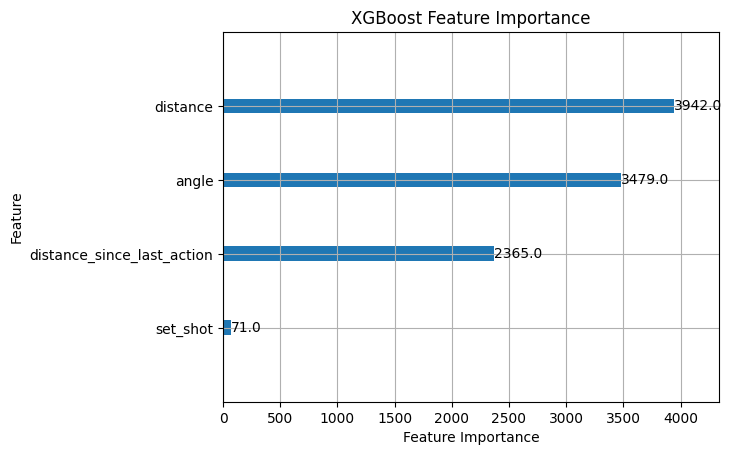

In [56]:
ax = xgb_model_evaluator.plot_feature_importance()

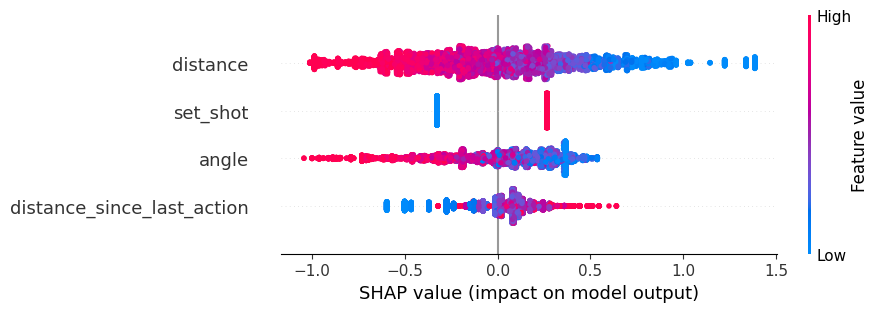

In [62]:
xgb_model_evaluator.plot_shap_beeswarm(X_test, y_test, specified_class=1, max_display=10)

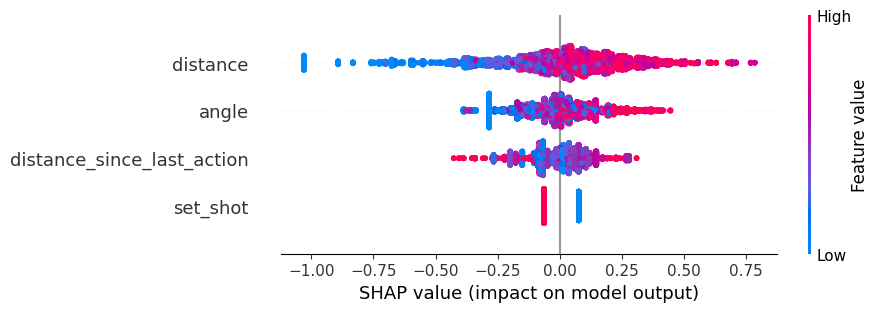

In [63]:
xgb_model_evaluator.plot_shap_beeswarm(X_test, y_test, specified_class=0, max_display=10)

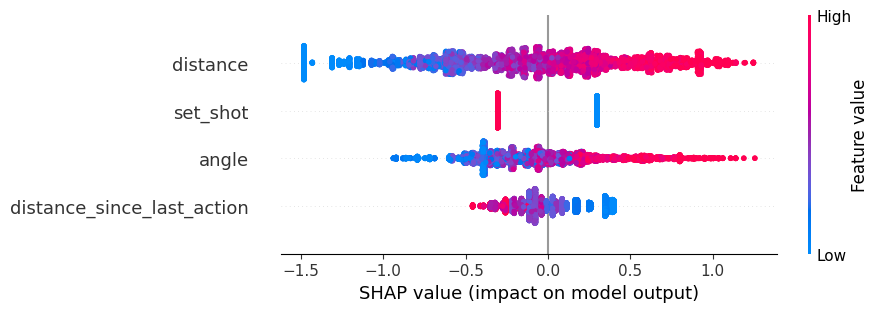

In [64]:
xgb_model_evaluator.plot_shap_beeswarm(X_test, y_test, specified_class=2, max_display=10)

Export (or Upload) Predictions

In [70]:
result_map_rev = {0: 'behind', 1: 'goal', 2: 'miss'}

In [71]:
shots = chains.loc[X_shots.index]
shots['predicted_result'] = xgb_clf.predict(X_shots[selected_features]).flatten()
shots[[f'{result_map_rev[x]}_probas' for x in xgb_clf.classes_]] = xgb_clf.predict_proba(X_shots[selected_features])
shots['xscore'] = shots['goal_probas']*6 + shots['behind_probas']
shots = pd.concat([shots, X_shots], axis=1)
shots.head()

CD_Player_ID  Chain_Number Team_Chain Initial_State Final_State  \
47    CD_I990609             5   Brisbane      possGain      behind   
111   CD_I294518            12   Brisbane      possGain      behind   
195  CD_I1006126            22     Sydney       throwIn      behind   
206   CD_I997100            24     Sydney      possGain        goal   
217   CD_I996765            25     Sydney  centreBounce        goal   

     Period_Number  Period_Duration_Chain_Start Description     Disposal  \
47             1.0                         50.0        Kick  ineffective   
111            1.0                        270.0        Kick  ineffective   
195            1.0                        550.0        Kick  ineffective   
206            1.0                        576.0        Kick    effective   
217            1.0                        659.0        Kick    effective   

    Shot_At_Goal Behind_Detail  Order  Period_Duration     x     y Home_Team  \
47          True           NaN   48.0            118.0  44.0  12.0    Sydney   
111         True           NaN  112.0            327.0  56.0 -33.0    Sydney   
195         True           NaN  196.0            558.0  64.0  15.0    Sydney   
206         True           NaN  207.0            596.0  58.0 -21.0    Sydney   
217         True           NaN  218.0            677.0  51.0  28.0    Sydney   

    Away_Team Home_Team_Direction_Q1  Venue_Width  Venue_Length  \
47   Brisbane                  right        141.0         160.0   
111  Brisbane                  right        141.0         160.0   
195  Brisbane                  right        141.0         160.0   
206  Brisbane                  right        141.0         160.0   
217  Brisbane                  right        141.0         160.0   

              Player      Team                     Match_ID        Player_ID  \
47   Charlie Cameron  Brisbane  AFL_2024_F4_Sydney_Brisbane  charlie_cameron   
111      Joe Daniher  Brisbane  AFL_2024_F4_Sydney_Brisbane      joe_daniher   
195  James Rowbottom    Sydney  AFL_2024_F4_Sydney_Brisbane  james_rowbottom   
206     Will Hayward    Sydney  AFL_2024_F4_Sydney_Brisbane     will_hayward   
217       Tom Papley    Sydney  AFL_2024_F4_Sydney_Brisbane       tom_papley   

     result  score  miss  behind  goal  predicted_result  behind_probas  \
47   behind      1     0       1     0                 1       0.254841   
111  behind      1     0       1     0                 1       0.333719   
195  behind      1     0       1     0                 1       0.281216   
206    goal      6     0       0     1                 1       0.363381   
217    goal      6     0       0     1                 0       0.507870   

     goal_probas  miss_probas    xscore     angle  angle_degrees  \
47      0.696026     0.049133  4.430995  0.321751      18.434949   
111     0.565133     0.101148  3.724517  0.942000      53.972627   
195     0.606680     0.112104  3.921295  0.753151      43.152390   
206     0.506323     0.130295  3.401321  0.762147      43.667780   
217     0.254383     0.237747  2.034168  0.767856      43.994914   

     chain_duration description_0      description_1          description_2  \
47             68.0          Kick       Mark On Lead  Kick Inside 50 Result   
111            57.0          Kick       Mark On Lead  Kick Inside 50 Result   
195             8.0          Kick     Loose Ball Get                 Gather   
206            20.0          Kick     Free Advantage               Free For   
217            18.0          Kick  Handball Received               Handball   

             description_3   distance  distance_log  \
47           Kick Into F50  37.947332      3.636199   
111          Kick Into F50  40.804412      3.708790   
195     Contested Knock On  21.931712      3.087934   
206  Kick Inside 50 Result  30.413813      3.414897   
217                 Gather  40.311289      3.696632   

     distance_since_last_action  distance_squared  distance_to_goal_x  \
47              

In [72]:
shots.to_csv(r"/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/data/predictions/shots_xs_xgboost.csv", index=False)